# Neural networks
Good article of the basics: https://victorzhou.com/blog/intro-to-neural-networks/   
Great video of the basics: https://www.youtube.com/watch?v=aircAruvnKk

### Introduction to Neural Networks.


A next step from a single perceptron -as seen in the last lecture- to an image classifier as above is a Multi-layer Perceptron.

![](http://www.saedsayad.com/images/Perceptron_bkp_1.png)



The code in the following is adapted from Chapter 18 "Neural Networks" in the Data Science from Scratch book. The code can be found at: https://github.com/joelgrus/data-science-from-scratch/blob/master/scratch/neural_networks.py


## Classification of handwritten numbers
See this [excelent video](https://www.youtube.com/watch?v=aircAruvnKk)

(1797, 64)


<Figure size 432x288 with 0 Axes>

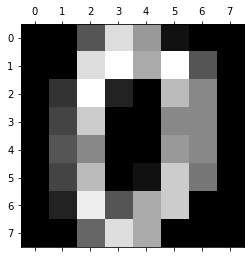

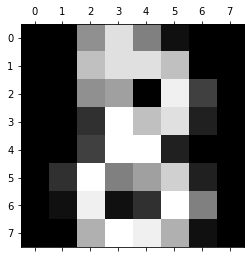

In [1]:
# Classify handwritten digits

from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

import matplotlib.pyplot as plt 
plt.gray() 
plt.matshow(digits.images[0]) 
plt.matshow(digits.images[8]) 
#plt.show() 

In [1]:
# 3. Import libraries and modules
import numpy as np
np.random.seed(123)  # for reproducibility
 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
 
# 4. Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
 
# 5. Preprocess input data
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
 
# 6. Preprocess class labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
 
# 7. Define model architecture
model = Sequential()
 
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(1,28,28)))
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
 
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
model.fit(X_train, Y_train, 
          batch_size=32, nb_epoch=10, verbose=1)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)

Using TensorFlow backend.


11493376/11490434 [==============================] - 94s 8us/step


/home/thomas/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(1, 28, 28...)`


ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_1/convolution' (op: 'Conv2D') with input shapes: [?,1,28,28], [3,3,28,32].